In [2]:
"""
Final Edit on Sunday 19 May 2024
Author: Arthur Lee
Original Author: Zaw
"""

#import libraries
import numpy as np
import pandas as pd
import os
from scipy import stats
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import warnings
from sklearn.linear_model import LinearRegression
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt

### Load the subject and stiumuls repect to their speed
path = os.getcwd()
dirname = os.path.dirname(path)
# for PD
data_file = ['data/one_degPD.csv','data/two_degPD.csv','data/four_degPD.csv','data/six_degPD.csv','data/eight_degPD.csv']
# for HC
# data_file = ['data/one_degHC.csv','data/two_degHC.csv','data/four_degHC.csv','data/six_degHC.csv','data/eight_degHC.csv']
# for PD
# data_file = 'data/PD/one_deg.csv'

# data_path = os.path.join(dirname,data_file)
# data = pd.read_csv(data_path)
# data= pd.read_csv(data_path)

#import CSV data for stimulus
path_sti = os.getcwd()
dirname_sti = os.path.dirname(path_sti)
# data_file_sti = 'data/1_degSti.xlsx'
data_file_sti = ['data/1_degSti.xlsx','data/2_degSti.xlsx','data/4_degSti.xlsx','data/6_degSti.xlsx','data/8_degSti.xlsx']

FirstTrialHC = []

if 'HC' in data_file[0]:
# #List of subject codes (e.g. PD001, PD002, etc.)
    subject_codes = ["PD001","PD002","PD003","PD004","PD005","PD006","PD007","PD008","PD009","PD010",
                    "PD011","PD012","PD013","PDN015","PDN017","PDN018","PDN019","PDN022","PD026"]
else:
    subject_codes = ['PD104','PD106','PD107','PD108','PD109','PD111','PD112','PD119','PD120','PD121',
                    'PD122','PD126','PDPY101','PDQE102','PDQE103','PDQE104','PDQE105','PDQE107','PDQE108','PDQE112',
                    'PDQE113','PDQE114','PDQE115','PDPW104','PDPW106','PDPW107','PDPW109','PDPW110','PDPW111','PDPW112',
                    'PDPW113']
    


In [3]:
# Define the function
def func(x, a, b, c) -> float:  #Position as a function of time.
    """
    Defining the triangle function
    """
    return a*(2/np.pi)*np.arcsin(np.sin(np.pi*(b*x+c)))

def check_sign(x):
    if x > 0:
        return "Positive"
    else:
        return "Negative"

def moving_average(a:list, n:int=3) -> list:
    """
    Moving average calculation, takes a list and number of data point to smooth over
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def derivative(list_of_x:list, list_of_y:list) -> list:
    """
    Calculating the derivative using first principle, "rise over run". However we are taking 5 points ahead and not a point ahead.
    formula is (y5-y1)/(x5-x1)
    """
    temp = []
    for i in range(len(list_of_x)-5):
        temp.append((list_of_y[i+5]-list_of_y[i])/(list_of_x[i+5]-list_of_x[i]))
    return temp
        
def filter_index(derivative_of_idx_list:list,idx_list:list) -> list:
    """
    Filtering for cusps, as we know where we are replacing nan with 0s.
    By taking derivative we will know location of large cusps based on the difference between index numbers
    """
    temp = []
    temp.append(idx_list[0])
    for change in range(len(derivative_of_idx_list)):
        if derivative_of_idx_list[change] >= 100:
            temp.append(idx_list[change])
            temp.append(idx_list[change+1])
    temp.append(idx_list[len(idx_list)-1])
    return temp

def segmentation(idx_list:list,data_list:list) -> list:
    """
    Splitting segments based on peaks from cusps and derivatives. 
    Also removed first 5 and last 5 point from each segment to reduce noise    
    
    For this function, we will check for a few condition:
    if we do not detect any peaks, we will directly append the list.
    """
    temp = []
    if len(idx_list) == 0:
        return [data_list]
    else:
        if idx_list[0] > 5:
            temp.append(data_list[5:idx_list[0]-5])
        for idxs in range(1,len(idx_list)-1,2):
            temp.append(data_list[idx_list[idxs]+5:idx_list[idxs+1]-5])
        temp.append(data_list[idx_list[len(idx_list)-1]+5:len(data_list)-5])
    return temp

def filter_seg(big_list:list) -> list:
    """
    Filtering list that are too short
    Deprecated probably
    """
    temp = []
    for l_s in big_list:
        for s_s in l_s:
            if s_s.size >= 5:
                temp.append(s_s)     
    return temp

def slope_calc(X,Y):
    """
    X and Y accept a numpy array
    Math for calculating linear regression, https://en.wikipedia.org/wiki/Linear_least_squares and https://gist.github.com/grisaitis/cf481034bb413a14d3ea851dab201d31
    returns:
        beta_hat - the coefficient of the linear regression (list)
        X_with_intercept - intercept of the linear regression (list)
    """
    N = np.shape(X)[0]
    p = 2
    X = np.resize(X,(np.shape(X)[0],1))
    
    X_with_intercept = np.empty(shape=(N,p),dtype=float)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = np.array(X)
    
    beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ Y
    return beta_hat,X_with_intercept

def prediction(beta_list, X) -> np.array:
    '''
    Calculate the output based on the linear regression calcualted using slope_calc above
    '''
    return X*beta_list[1] + beta_list[0]

subject: PD104
subject: PD106
subject: PD107
subject: PD108
subject: PD109
subject: PD111
subject: PD112
subject: PD119
subject: PD120
subject: PD121
subject: PD122
subject: PD126
subject: PDPY101
subject: PDQE102
subject: PDQE103
subject: PDQE104
subject: PDQE105
subject: PDQE107
subject: PDQE108
subject: PDQE112
subject: PDQE113
subject: PDQE114
subject: PDQE115
subject: PDPW104
subject: PDPW106
subject: PDPW107
subject: PDPW109
subject: PDPW110
subject: PDPW111
subject: PDPW112
subject: PDPW113


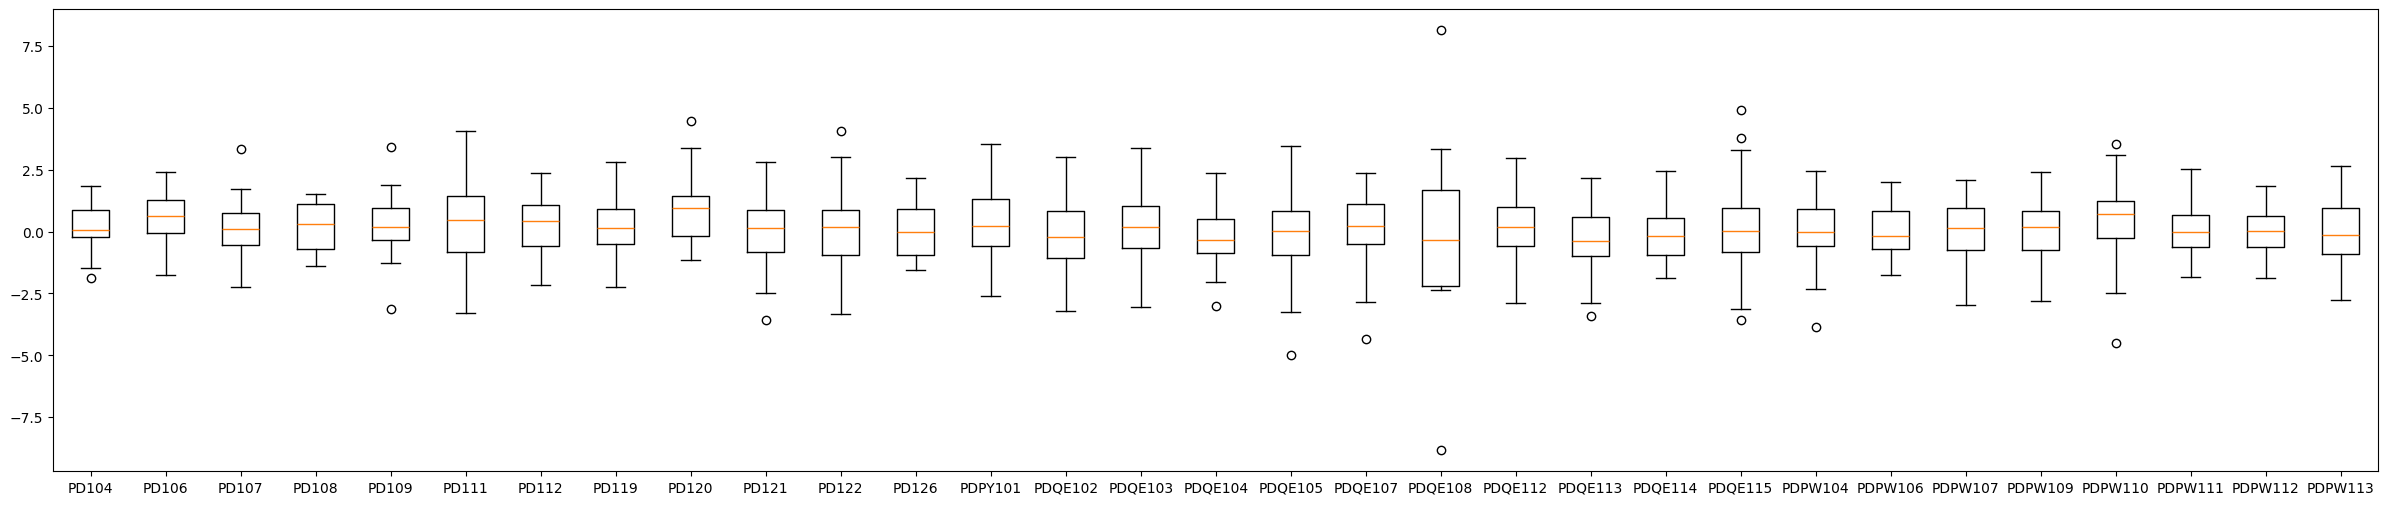

subject: PD104
subject: PD106
subject: PD107
subject: PD108
subject: PD109
subject: PD111
subject: PD112
subject: PD119
subject: PD120
subject: PD121
subject: PD122
subject: PD126
subject: PDPY101
subject: PDQE102
subject: PDQE103
subject: PDQE104
subject: PDQE105
subject: PDQE107
subject: PDQE108
subject: PDQE112
subject: PDQE113
subject: PDQE114
subject: PDQE115
subject: PDPW104
subject: PDPW106
subject: PDPW107
subject: PDPW109
subject: PDPW110
subject: PDPW111
subject: PDPW112
subject: PDPW113


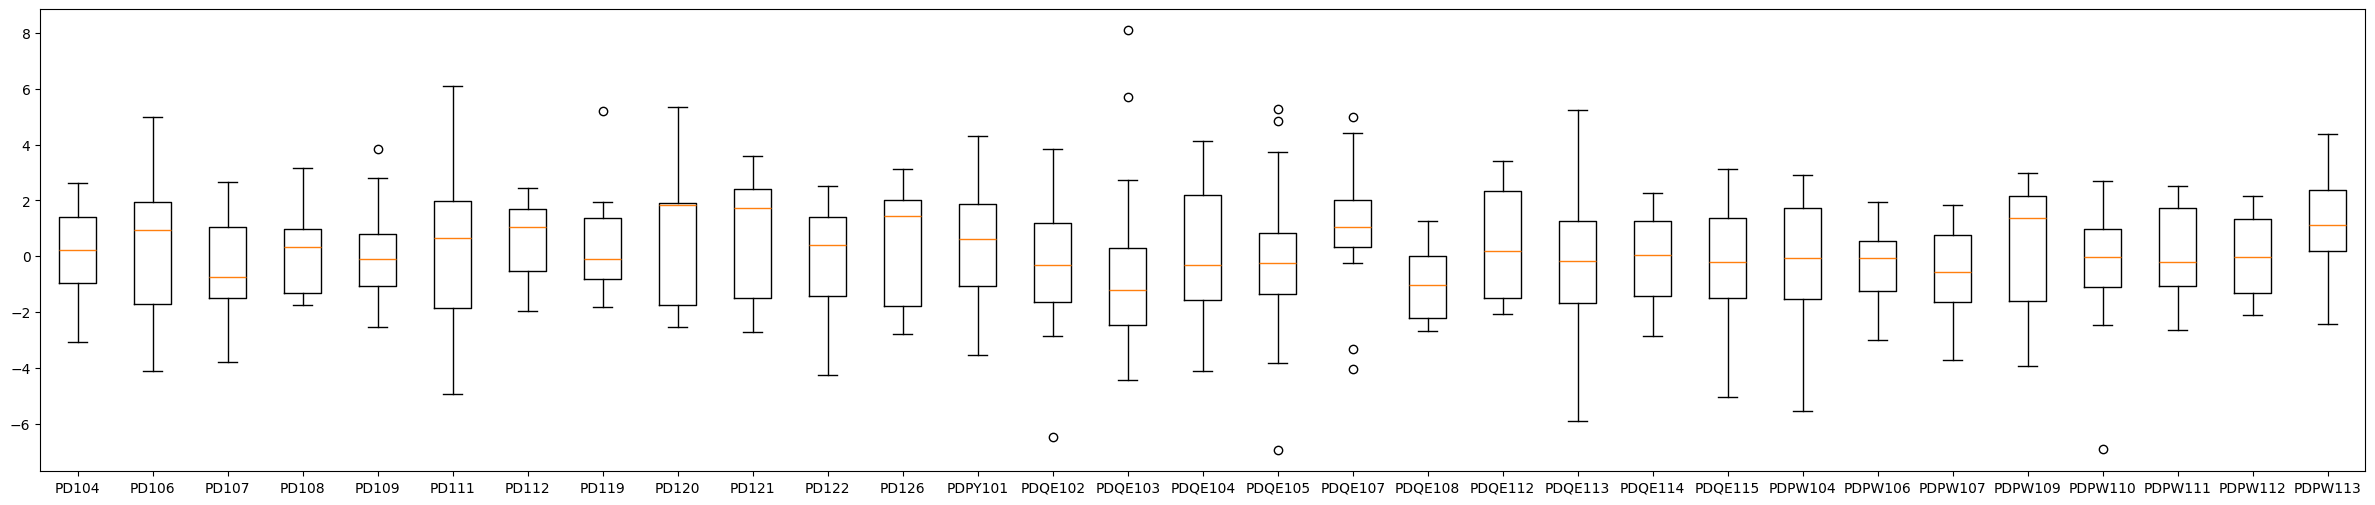

subject: PD104
subject: PD106
subject: PD107
subject: PD108
subject: PD109
subject: PD111
subject: PD112
subject: PD119
subject: PD120
subject: PD121
subject: PD122
subject: PD126
subject: PDPY101
subject: PDQE102
subject: PDQE103
subject: PDQE104
subject: PDQE105
subject: PDQE107
subject: PDQE108
subject: PDQE112
subject: PDQE113
subject: PDQE114
subject: PDQE115
subject: PDPW104
subject: PDPW106
subject: PDPW107
subject: PDPW109
subject: PDPW110
subject: PDPW111
subject: PDPW112
subject: PDPW113


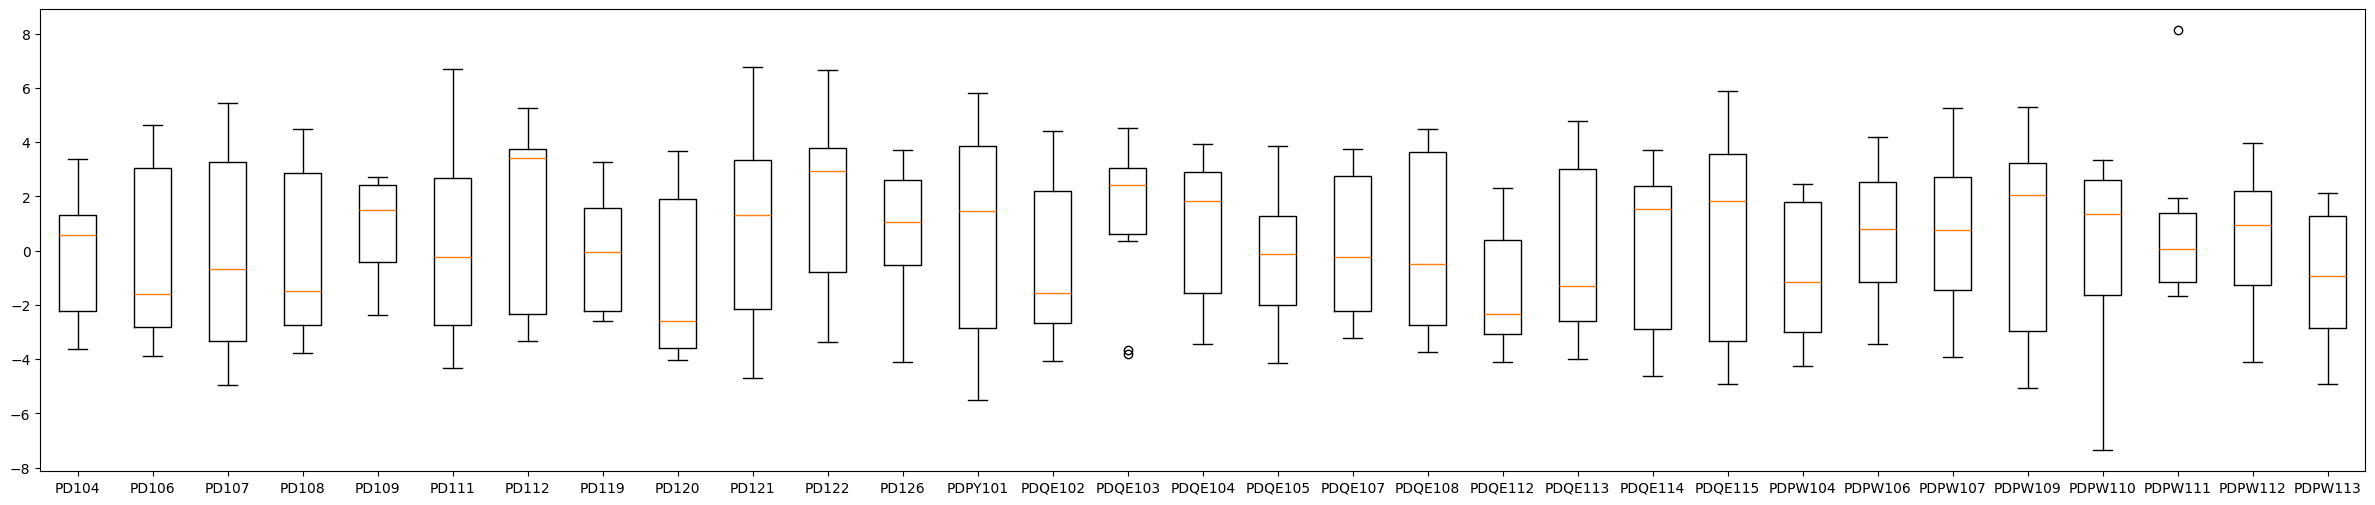

subject: PD104
subject: PD106
subject: PD107
subject: PD108
subject: PD109
subject: PD111
subject: PD112
subject: PD119
subject: PD120
subject: PD121
subject: PD122
subject: PD126
subject: PDPY101
subject: PDQE102
subject: PDQE103
subject: PDQE104
subject: PDQE105
subject: PDQE107
subject: PDQE108
subject: PDQE112
subject: PDQE113
subject: PDQE114
subject: PDQE115
subject: PDPW104
subject: PDPW106
subject: PDPW107
subject: PDPW109
subject: PDPW110
subject: PDPW111
subject: PDPW112
subject: PDPW113


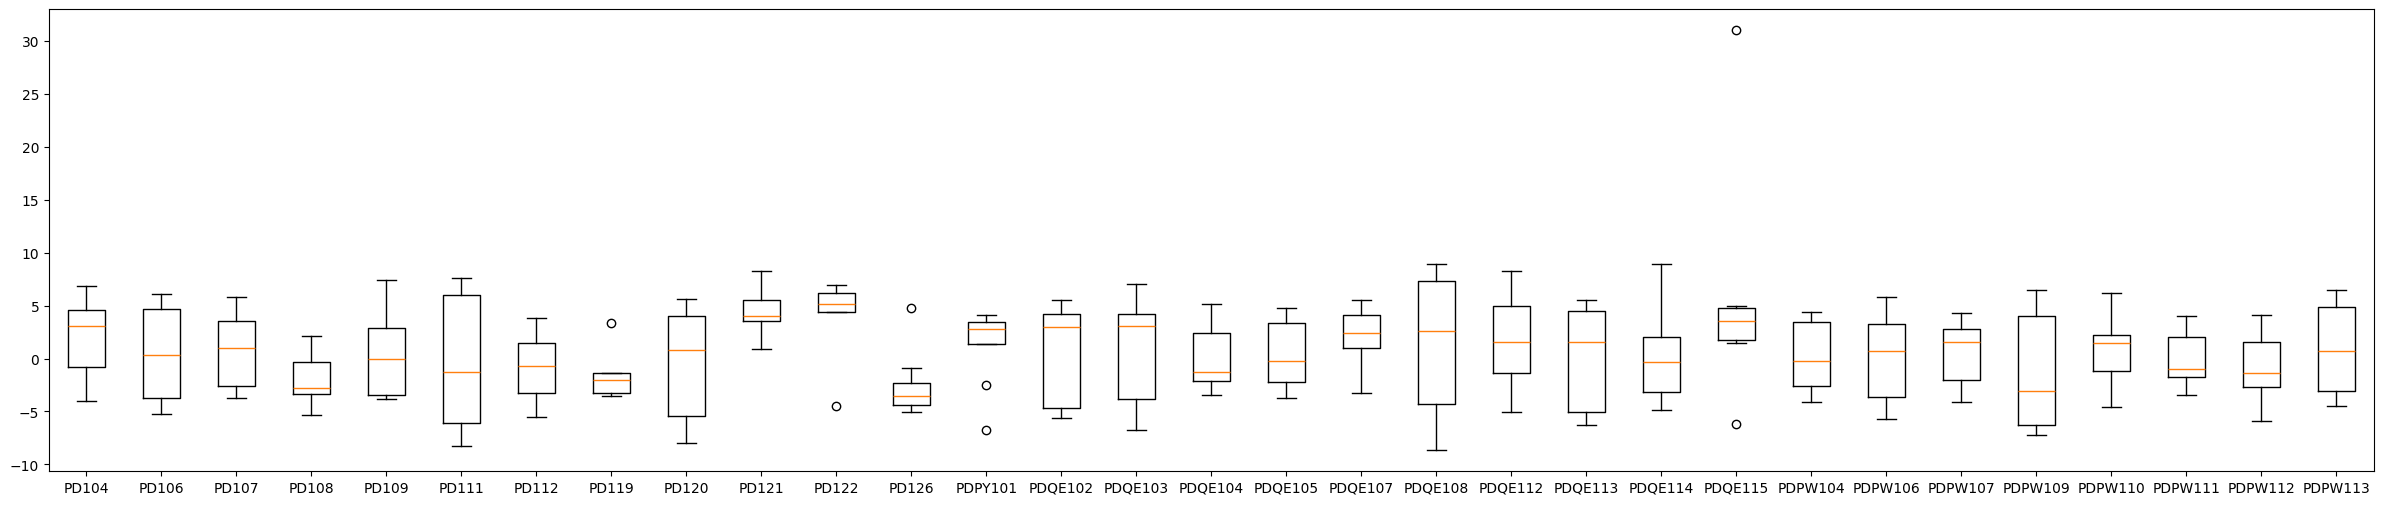

subject: PD104
subject: PD106
subject: PD107
subject: PD108
subject: PD109
subject: PD111
subject: PD112
subject: PD119
subject: PD120
subject: PD121
subject: PD122
subject: PD126
subject: PDPY101
subject: PDQE102
subject: PDQE103
subject: PDQE104
subject: PDQE105
subject: PDQE107
subject: PDQE108
subject: PDQE112
subject: PDQE113
subject: PDQE114
subject: PDQE115
subject: PDPW104
subject: PDPW106
subject: PDPW107
subject: PDPW109
subject: PDPW110
subject: PDPW111
subject: PDPW112
subject: PDPW113


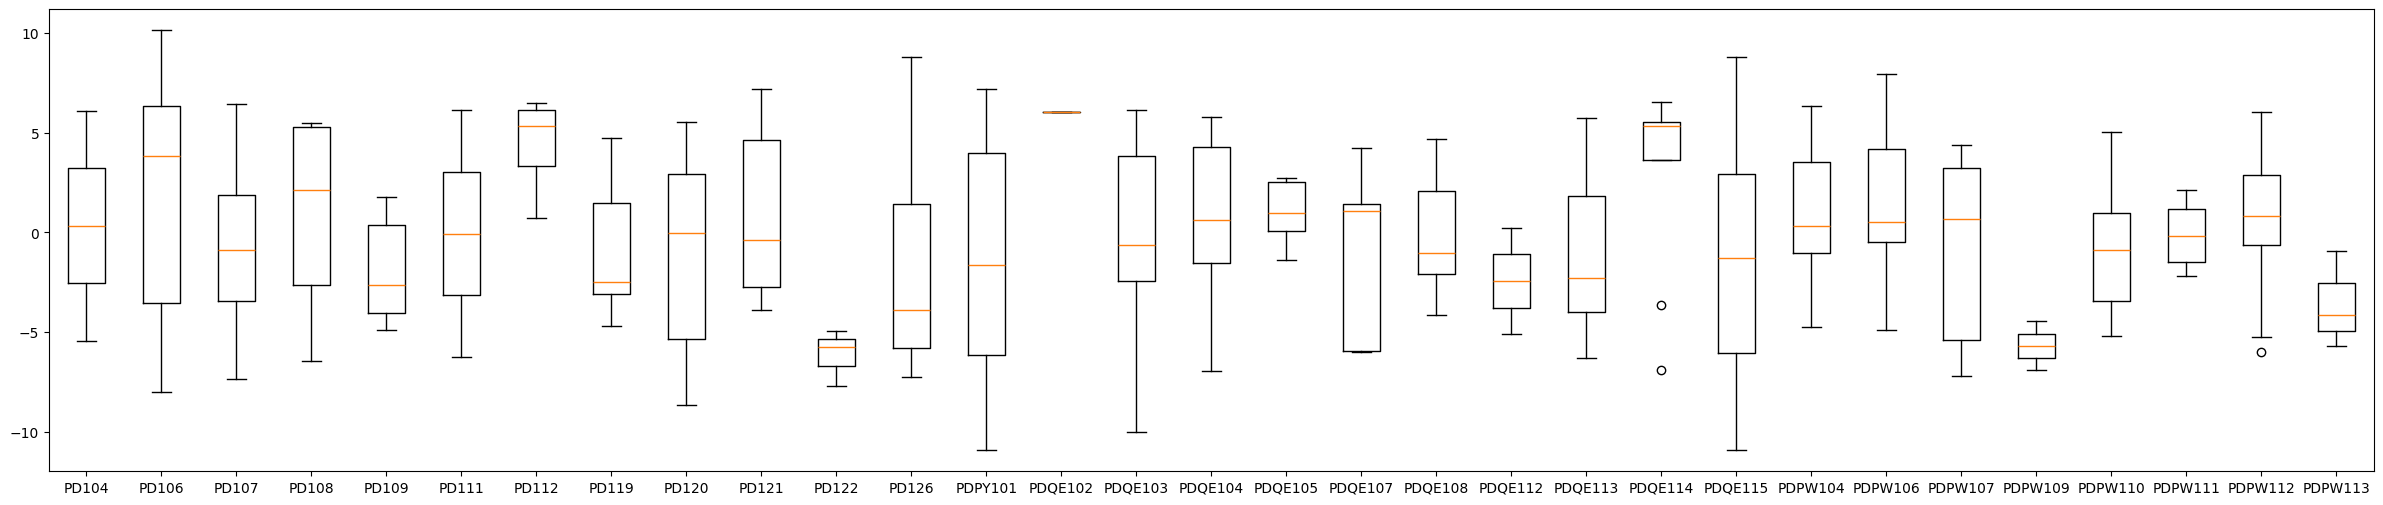

In [15]:
header = 'subject code, average segment lengths, mode segment lengths, number of segments, average slope, standard deviation of slope, average slope after filtering, standard deviation of slope after filtering\n'

for i, txt in enumerate(data_file):

    # Trigonometric Functions
    
    #initial guesses( This has to change depend on stimulus speed)
    #for 1 degree per second: [10, 0.05, 0]
    #for 2 degrees per second: [10, 0.1, 0]
    #for 4 degrees per second: [10, 0.2, 0]
    #for 6 degrees per second: [10, 0.3, 0]
    #for 8 degrees per second: [10, 0.4, 0]
    
    # Stimulus data
    data_path_sti = os.path.join(dirname_sti,data_file_sti[i])
    rawdata = pd.read_excel(data_path_sti)
    data_st = np.array(rawdata[1:],dtype=float)
    # Perform curve fitting
    time = data_st[:,1]
    position = data_st[:,0]
    
    #saving time by analyzing everything at once
    if "one" in txt:
        InitialGuess = [10, 0.05, 0] 
        outname = 'oneDegPD_out.csv'
    elif "two" in txt:
        InitialGuess = [10, 0.1, 0]
        outname = 'twoDegPD_out.csv'
    elif "four" in txt:
        InitialGuess =  [10, 0.2, 0]
        outname = 'fourDegPD_out.csv'
    elif "six" in txt:
        InitialGuess = [10, 0.3, 0]
        outname = 'sixDegPD_out.csv'
    elif "eight" in txt:
        InitialGuess = [10, 0.4, 0]
        outname = 'eightDegPD_out.csv'
    
    with open(outname, 'w') as f:
        f.writelines(f'{header}')

    popt, pcov = curve_fit(func,position,time, p0=InitialGuess) #using the curve fitting function
    length = 25 #filter for minimum segment length -> PROBABLY NEED SOME TWEEKING
        
    # Extract the optimal values of a, b, and c
    a, b, c = popt
    # print("a =", a)
    # print("b =", b)
    # print("c =", c)
    
    #for plotting a box and whisker plot
    collect_slopes = []
    
    for subject_code in subject_codes:

        print(f'subject: {subject_code}')
        data_path = os.path.join(dirname,txt)
        # data = pd.read_csv(data_path)
        data= pd.read_csv(data_path)
        # print('File '+ str(subject_code)+ ' is started.') 
        x_column = f'x1_{subject_code}'
        y_column = f'y1_{subject_code}'

        # Check if both columns exist in the DataFrame before accessing them
        if x_column in data.columns and y_column in data.columns:
            data_hc = data[[x_column, y_column]]
        else:
            print(f"Columns for subject code {subject_code} not found. Skipping...")
            continue
        
        #reading the data and moving them to list, and putting them into a np.array
        y_data = np.array(data_hc[y_column])
        x_data = np.array(data_hc[x_column])
        
        nan_removed_y_data = []
        nan_removed_x_data = []
        
        #getting rid of nans
        for i,dp in enumerate(y_data):
            if np.isnan(dp) == False:
                nan_removed_x_data.append(x_data[i])
                nan_removed_y_data.append(y_data[i])

        nan_removed_y_data = np.array(nan_removed_y_data,dtype='float64') #setting the list as a numpy array
        
        fit_pos = func(y_data,a,b,c) #apply the triangle function to the data
        
        # data_hc = data[['x1_PD001','y1_PD001']] # change the ID each subject code(e.g PD001 or PD003)
        # y_data = data_hc[data_hc.columns[0]]
        # x_data = data_hc[data_hc.columns[1]]
        
        # Find the residual
        # Different(aka residual)
        # diff = y_data - fit_pos #keeps nans

        #transposed the data for stacking during testing for plotting
        # diff = np.transpose(diff)
        # x_data = np.transpose(x_data)
        # temp = np.column_stack((x_data,diff))
        
        # setting the residue as np array
        diff = np.array(y_data - fit_pos)
        
        #removing nans from diff
        nan_removed_diff = []
        for i, dp in enumerate(diff):
            if np.isnan(dp) == False:
                nan_removed_diff.append(diff[i])
            
        #probably redundant, but it is here for plotting purposes
        processed_diff_y,processed_diff_x = [],[]
        for rows in range (len(nan_removed_diff)):
            processed_diff_y.append(nan_removed_diff[rows])
            processed_diff_x.append(nan_removed_x_data[rows])
            
        #take the derivative to find cusps/gaps/any large change in data
        diff_derivative = np.abs(derivative(processed_diff_x,processed_diff_y))**2

        # diff_derivative = np.square(diff_derivative)*1E8 #need to multiply by 1E8 for scaling, else it will be too small
        peaks = []
        final_x,final_y = [],[]

        peaks.append(find_peaks(diff_derivative,height=np.median(diff_derivative)*5,width=0))

        segmented_x = segmentation(peaks[0][0],nan_removed_x_data)
        segmented_y = segmentation(peaks[0][0],nan_removed_y_data)
        
        # for i, (x_list,y_list) in enumerate(zip(segmented_x,segmented_y)):
        #     print(x_list)
        #     print(y_list)

        final_seg_x, final_seg_y = [],[]
        
        for segments,(x_list,y_list) in enumerate(zip(segmented_x,segmented_y)):
            if len(x_list) >= length:
                final_seg_x.append(x_list)
                final_seg_y.append(y_list)
                    
        slopes = []
        intercepts = []
        errors = []
        r_squared = []
        final_seg_lengths =[]
        
        #for loop for all the filtered segments
        for segs,(content_x,content_y) in enumerate(zip(final_seg_x,final_seg_y)):
            final_seg_lengths.append(len(content_x)) 
            #calculate slope
            calc_slope,beta_1_coe = slope_calc(content_x,content_y)
            
            #append slopes and intercepts to a list
            slopes.append(calc_slope[1])
            intercepts.append(calc_slope[0])
            
            #calculate the error of the prediction vs the data to get an error of the slope
            y_error =  content_y - prediction(calc_slope,np.array(content_x))
            residuals_sum_of_squares = y_error.T @ y_error
            total_sum_of_sqaures = np.sum((content_y-np.average(content_y))**2)

            #calculates the coefficient of determination
            r_squared.append(1 - (residuals_sum_of_squares/total_sum_of_sqaures))
            sigma_squared_hat = residuals_sum_of_squares / (np.shape(content_x)[0]- 2)
            var_beta_hat = np.linalg.inv(beta_1_coe.T @ beta_1_coe) * sigma_squared_hat
            errors.append((var_beta_hat[1,1]**0.5,var_beta_hat[0,0]**0.5))
        
        final_slope = []
        
        for data in range (len(slopes)):
            if  0.35<=np.abs(slopes[data])<=1.1 : #and r_squared[data]>0.5 and errors[data][0]/np.abs(slopes[data]) <= 0.1:
                final_slope.append(slopes[data])

        # for seg_num,(x,y) in enumerate (zip(final_seg_x,final_seg_y)):
        #     if len(x) > 50:
        #         plt.plot(x,y)
        #         plt.show()
        #     print(slopes[seg_num])
        #     print(len(final_seg_x[seg_num]))
        
        collect_slopes.append(slopes)
        
        average_slope = np.round(np.average(np.abs(slopes)),3)
        average_slope_std = np.round(np.std(np.abs(slopes),ddof=1),3)
        average_filtered_slope = np.round(np.average(np.abs(final_slope)),3)
        average_slope_std = np.round(np.std(np.abs(final_slope),ddof=1),3)
        # print(slopes)
        
        #writing all the result to the csv file according to the header variable
        with open(outname, 'a+') as f:
            f.writelines(f'{subject_code},{np.round(np.average(final_seg_lengths),0)},{stats.mode(final_seg_lengths)[0]},\
                        {len(final_seg_x)},{average_slope},{average_slope_std},\
                        {average_filtered_slope},{average_slope_std},{len(final_slope)}\n')
    
    fig = plt.figure(figsize=(30,6))
    plt.boxplot(collect_slopes)
    x = np.arange(1,len(subject_codes)+1)
    plt.xticks(x,subject_codes)
    plt.show()
       
        
